# Problem Statement

Sales rank indicates the popularity of a product and the location of the product on the search page, and therefore can greatly influence customers’ decisions when choosing which product to buy rather than its competitors. The main objective of this project is to identify the relationship between reviews/ratings and sales ranks, and the importance of review features on sales rank.


# Sales score project Modeling Rationale

The following graphs will provide you with more detailed information on the selection of competing products. The red line visualizes the sales rank movement against time for the product in interest, which we name as product*. In week 1, from the same category, we take 10 products that have the closest sales ranks to the product* and their respective sales rank values are represented by yellow dots. Then, we bundle the 10 products into a product set called product set in week 1 by taking the average of their sales rank, and this product set is visualized by the yellow line. We will repeat this product set selection process every week, because we want to make two groups comparable in their current performances and investigate their difference in the next period. The same logic is applied to week 2 that we pick another product set with similar sales rank as the product*, and the product set in week 2 is plotted in green.

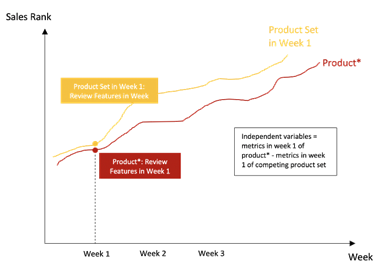


Now we will explain what “delta of delta log rank” is using the graph below. After selecting the comparable product set in week 1, we will calculate its delta log sales rank (yellow Δ symbol), which measures the change in sales rank from week 1 to week 2. The delta log sales rank of product* is also computed, which is denoted by the red Δ symbol. The delta of delta log rank is the difference between the red Δ and the yellow Δ. Therefore, in other words, delta of delta log rank is the difference in growth of sales rank between the product in interest and its competitors with similar performance in this time period.

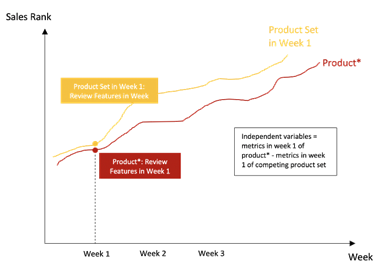

In the “key features” section, we introduce the relevant metrics that can help predict the sales rank. However, they are not directly put into the model. The independent variable eventually employed by the machine learning model is the difference between the key features of product* and its competing product set in week 1. For example, the difference of the average rating of the product* and the average rating of the product set in week 1 is used, instead of directly using the average rating of the product*. The interpretation is that we are interested in examining how much better the average rating the product* earns in this week than its competitors can contribute to its lower growth of sales rank than its competitors.

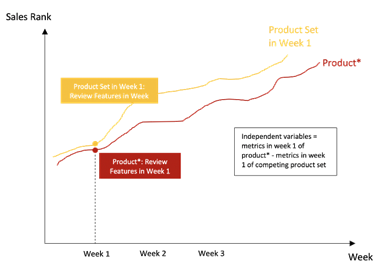

    Categories of Metrics used in the modelings
    Star-rating of reviews
        ●	Average star rating of reviews in one week & its lagged variables
        ●	Average star rating of reviews in two weeks & its lagged variables
        ●	Average star rating of reviews in one month
        ●	Average star rating of reviews in two months
        ●	Average star rating of reviews in one quarter 
        ●	Average star rating of all reviews
    Quantity of reviews
        ●	# of reviews in one week & its lagged variables
        ●	# of reviews in two weeks & its lagged variables
        ●	# of reviews in one month 
        ●	# of reviews in two months
        ●	# of reviews in one quarter
        ●	# of all reviews to the date
        ●	# of 5 star-rating reviews in one week & its lagged variables
        ●	# of 5 star-rating reviews in two weeks & its lagged variables
        ●	# of 5 star-rating reviews in one month
        ●	# of 5 star-rating reviews in two months
        ●	# of 5 star-rating reviews in one quarter
        ●	# of 5 star-rating reviews to the date
        ●	# of 1 star-rating reviews in one week & its lagged variables
        ●	# of 1 star-rating reviews in two weeks & its lagged variables
        ●	# of 1 star-rating reviews in one month
        ●	# of 1 star-rating reviews in two months
        ●	# of 1 star-rating reviews in one quarter
        ●	# of 1 star-rating reviews to the date
    Quality of reviews
        ●	% of non-anonymous customers for all reviews
        ●	Average word count of the recent 10 reviews
        ●	Average word count of all the reviews to the date
        ●	% of verified reviews in one month
        ●	% of verified reviews in one quarter
        ●	# of reviews with image in one month
        ●	# of reviews with image in one quarter
        ●	# of reviews with image to date
        ●	# of vine reviews in one month
        ●	# of vine reviews in one quarter
        ●	# of vine reviews to date
    Control variables	
        ●	Average weekly price 
        ●	Average monthly price


## Import libraries

In [246]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing, utils
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from IPython.display import Image
from statsmodels.graphics.factorplots import interaction_plot
from patsy import dmatrices
from sklearn.metrics import r2_score,accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict,train_test_split,StratifiedShuffleSplit
from sklearn.linear_model import Lasso,LinearRegression,Ridge,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os
from sklearn import tree
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

###  Exploratory Data Analysis

In [247]:
## import csv file generated from sales score aggreagaion model

panel_data = pd.read_csv("Avery_weekly_delta_delta_log_office_products_1069410_20200430.csv")
print("shape of panel data",panel_data.shape)
panel_data.head(5)

shape of panel data (18173, 67)


,Unnamed: 0,product,new_date,year_and_week,delta_delta_log_rank,delta_stars_one_week,delta_stars_pri_1stweek,delta_stars_pri_2ndweek,delta_stars_pri_3rdweek,delta_stars_pri_4thweek,...,delta_perc_verified_one_quarter,delta_perc_verified_one_month,delta_num_image,delta_num_image_one_quarter,delta_num_image_one_month,delta_num_vine,delta_num_vine_one_quarter,delta_num_vine_one_month,delta_avg_weekly_price,delta_avg_monthly_price
0,0,B00004Z5QO,2019-03-17,2019_11,0.200685,NaN,NaN,NaN,NaN,NaN,...,-0.051525,0.000000,-4.2,-0.8,-0.2,29.0,0.0,0.0,-2.267429,-2.193000
1,1,B00004Z5QO,2019-03-24,2019_12,-0.630498,NaN,NaN,NaN,NaN,NaN,...,-0.072016,0.000000,-2.2,-0.7,-0.3,29.0,0.0,0.0,-1.055571,-1.185913
2,2,B00004Z5QO,2019-03-31,2019_13,0.332706,NaN,NaN,NaN,NaN,NaN,...,0.019123,0.016667,-4.4,-0.9,-0.3,29.0,0.0,0.0,-0.824857,-1.037400
3,3,B00004Z5QO,2019-04-07,2019_14,0.337849,0.366667,NaN,NaN,NaN,NaN,...,0.040152,0.073333,-5.1,-0.9,-0.2,29.0,0.0,0.0,-2.239000,-2.545900
4,4,B00004Z5QO,2019-04-14,2019_15,-0.137742,0.366667,0.208333,NaN,NaN,NaN,...,0.018950,0.055075,-4.4,-0.8,-0.4,29.0,0.0,0.0,-2.579143,-2.801533


In [248]:
panel_data = panel_data[~np.isnan(panel_data["delta_delta_log_rank"])]
print("Shape of the input data \n", panel_data.shape)
print("\n \n")
panel_data.info()


Shape of the input data 
 (17534, 67)

 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17534 entries, 0 to 18172
Data columns (total 67 columns):
Unnamed: 0                         17534 non-null int64
product                            17534 non-null object
new_date                           17534 non-null object
year_and_week                      17534 non-null object
delta_delta_log_rank               17534 non-null float64
delta_stars_one_week               2678 non-null float64
delta_stars_pri_1stweek            2592 non-null float64
delta_stars_pri_2ndweek            2560 non-null float64
delta_stars_pri_3rdweek            2488 non-null float64
delta_stars_pri_4thweek            2447 non-null float64
delta_stars_two_weeks              4376 non-null float64
delta_stars_two_weeks_lag1         4285 non-null float64
delta_stars_two_weeks_lag2         4201 non-null float64
delta_stars_one_month              6670 non-null float64
delta_stars_two_months             8927 non-null fl

### The dependent variable 

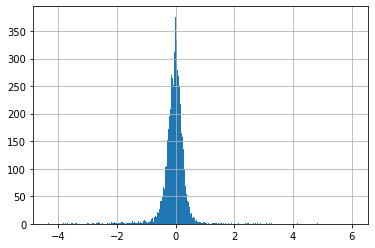

In [4]:
panel_data['delta_delta_log_rank'].hist(bins = 1000)

### The dependent variabe plotted against allindependent variables

C:\Users\tkblu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


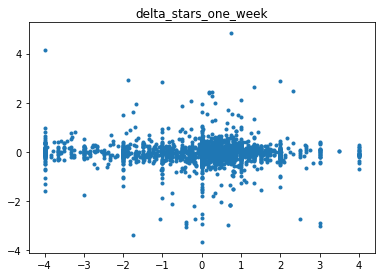

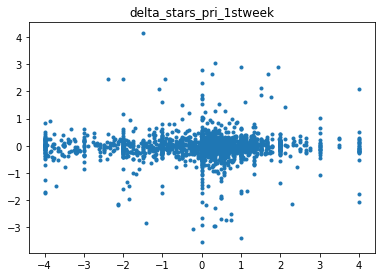

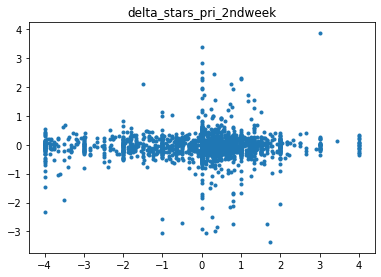

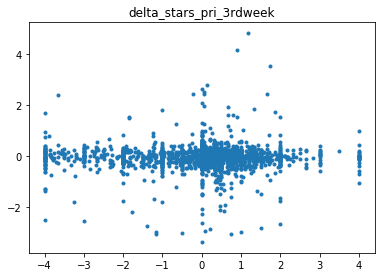

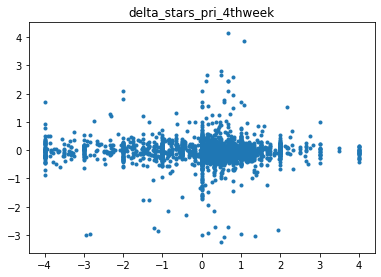

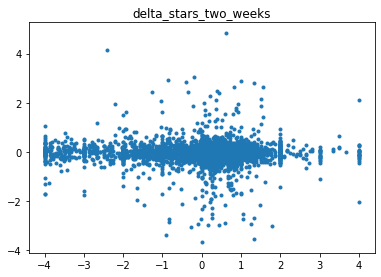

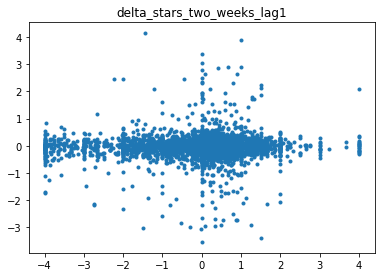

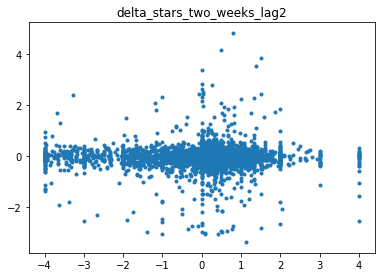

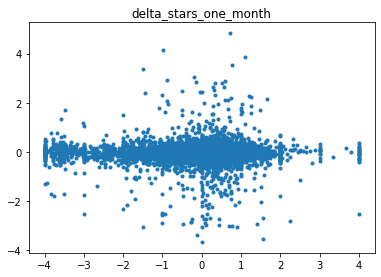

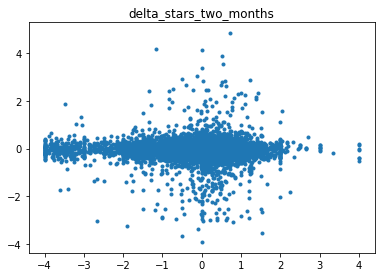

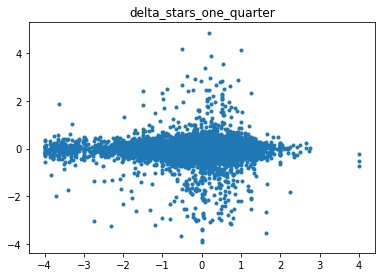

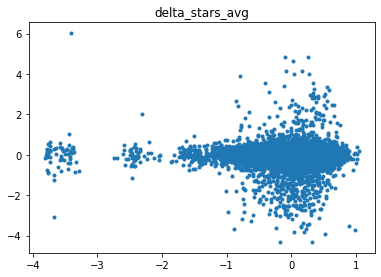

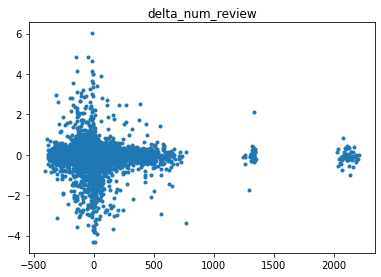

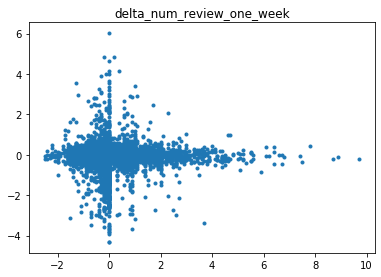

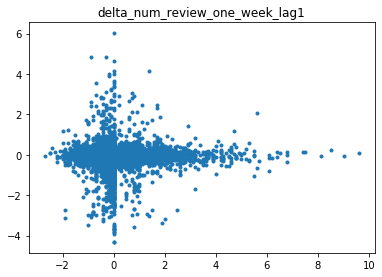

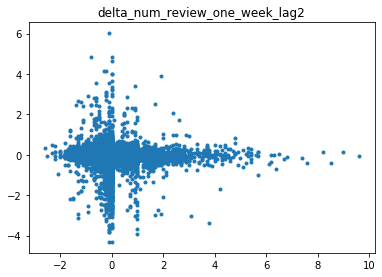

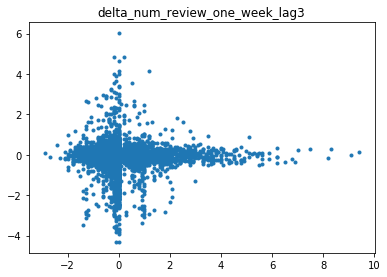

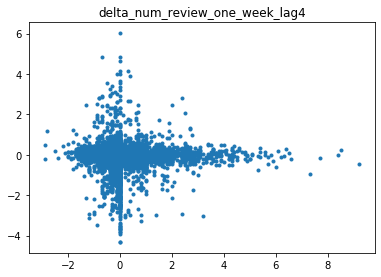

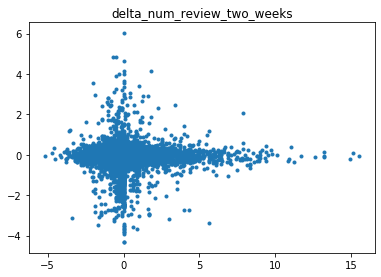

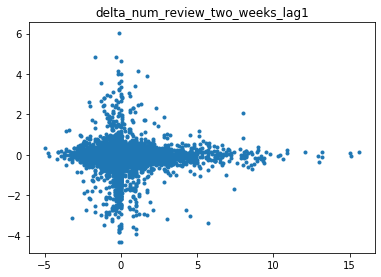

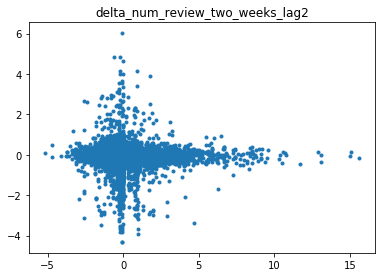

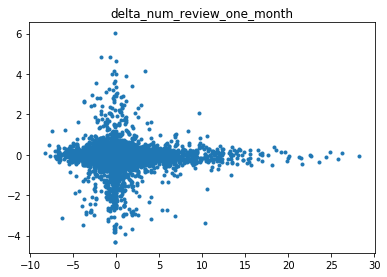

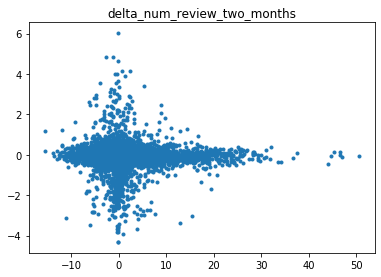

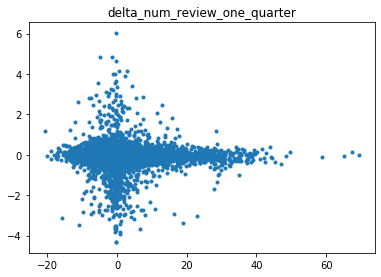

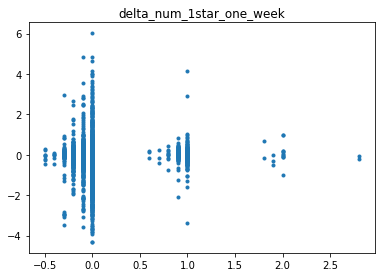

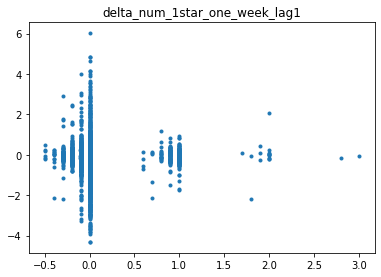

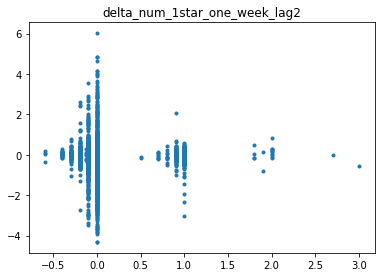

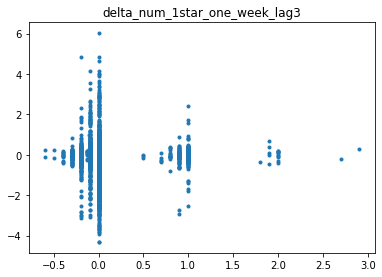

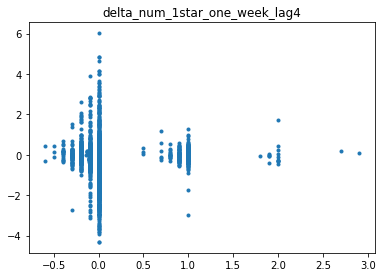

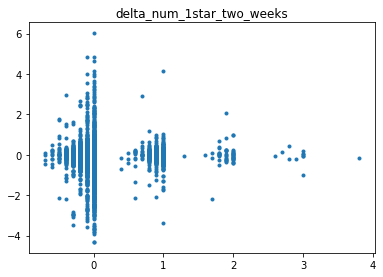

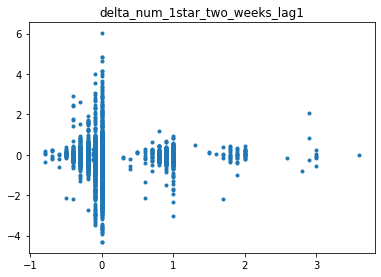

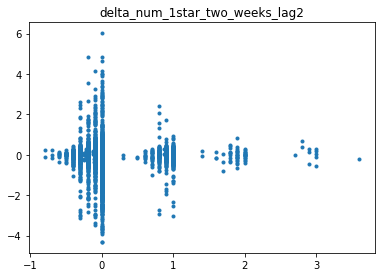

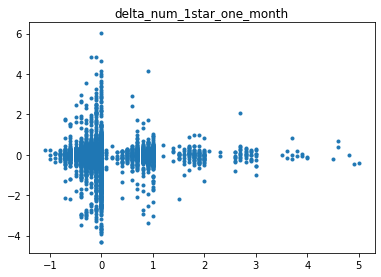

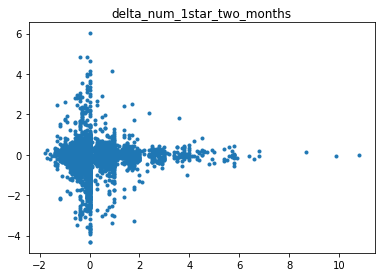

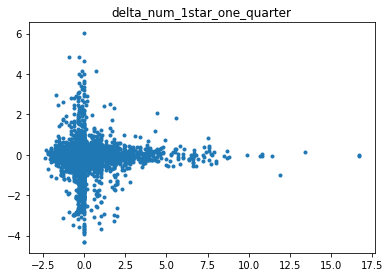

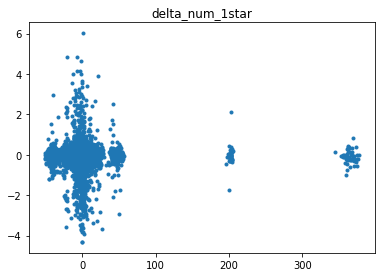

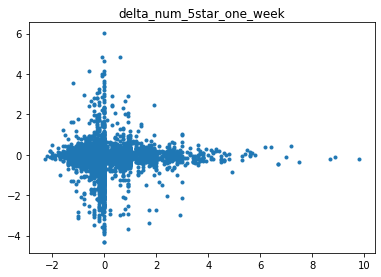

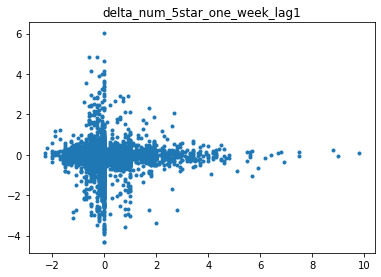

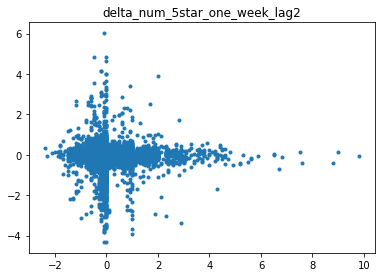

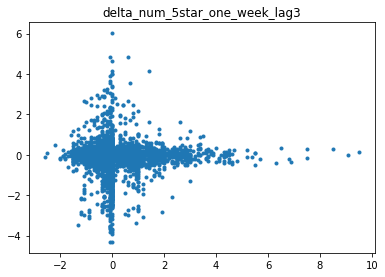

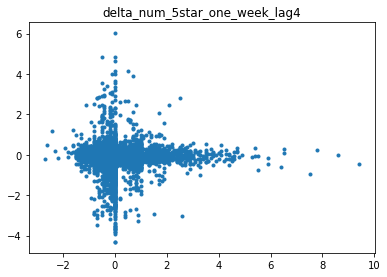

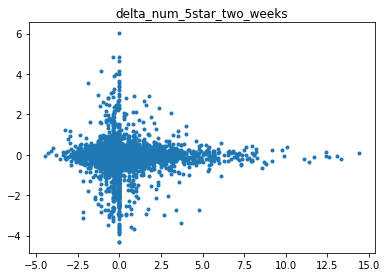

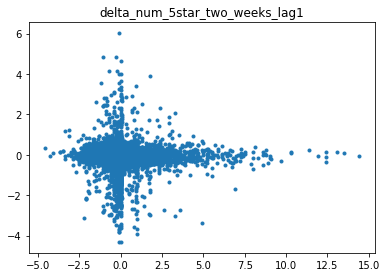

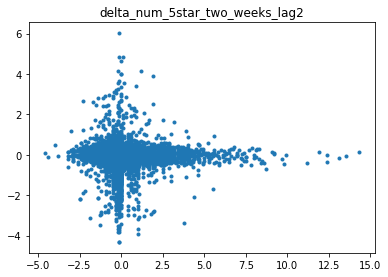

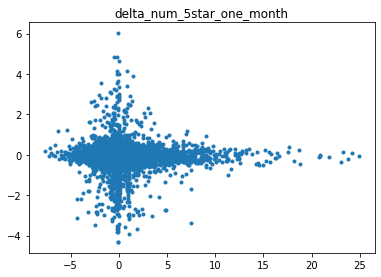

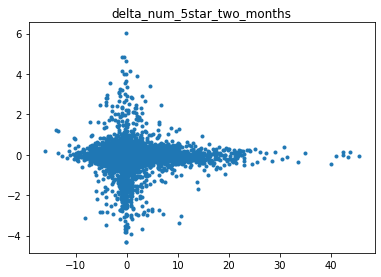

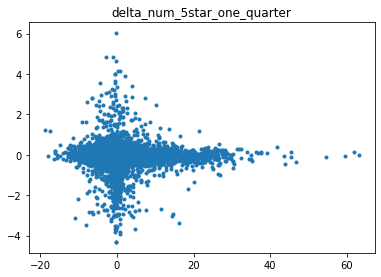

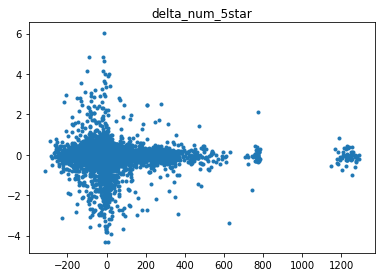

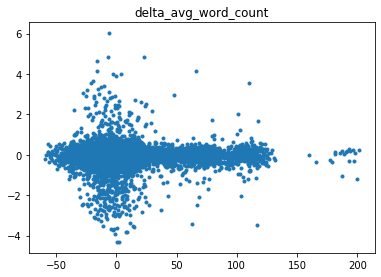

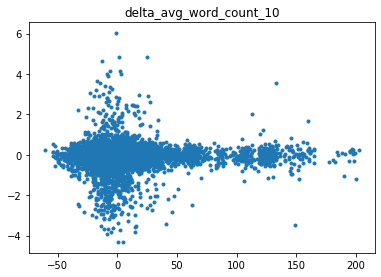

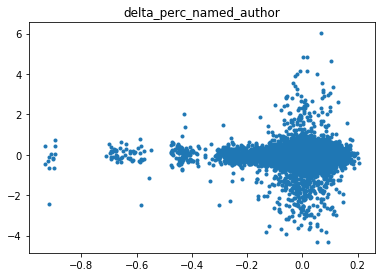

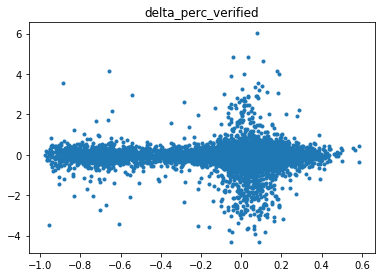

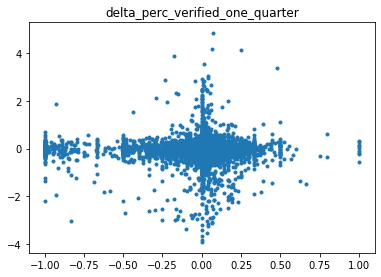

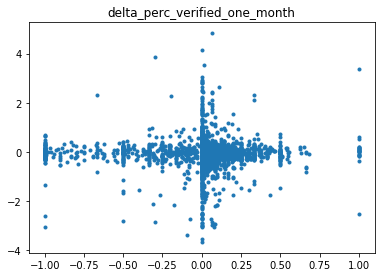

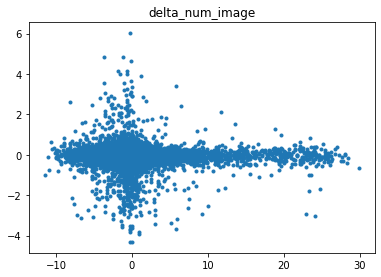

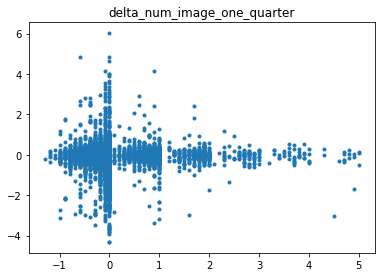

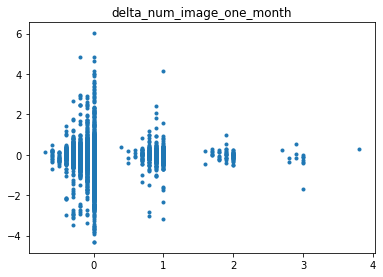

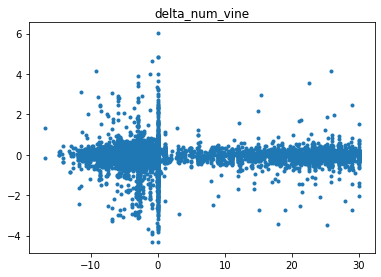

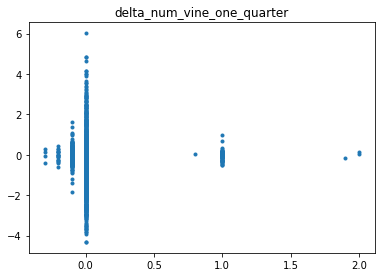

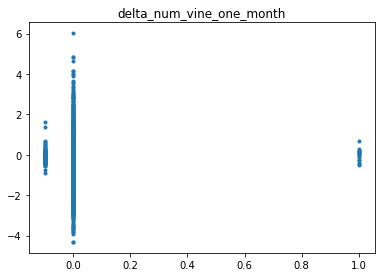

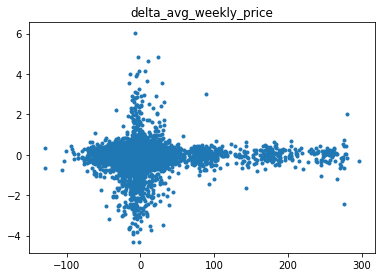

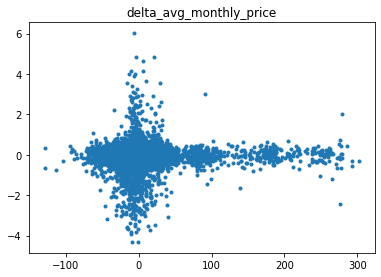

In [13]:
columns = panel_data.columns
columns = columns[5:]

for column in columns: 
    fig= plt.figure()
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    plt.plot(panel_data[column],panel_data['delta_delta_log_rank'],'.')
    axes.set_title(column)

## Modeling : feature selection

### Full model : Linear regression

Fitting in a preliminary model to see how the dependent variable is related to all review attributes 

In [249]:
y,X_part = dmatrices('delta_delta_log_rank ~delta_stars_one_week+delta_stars_pri_1stweek+delta_stars_pri_2ndweek+delta_stars_pri_3rdweek+delta_stars_pri_4thweek+delta_stars_two_weeks+delta_stars_two_weeks_lag1+delta_stars_two_weeks_lag2+delta_stars_one_month+delta_stars_two_months+delta_stars_one_quarter+delta_stars_avg+delta_num_review+delta_num_review_one_week+delta_num_review_one_week_lag1+delta_num_review_one_week_lag2+delta_num_review_one_week_lag3+delta_num_review_one_week_lag4+delta_num_review_two_weeks+delta_num_review_two_weeks_lag1+delta_num_review_two_weeks_lag2+delta_num_review_one_month+delta_num_review_two_months+delta_num_review_one_quarter+delta_num_1star_one_week+delta_num_1star_one_week_lag1+delta_num_1star_one_week_lag2+delta_num_1star_one_week_lag3+delta_num_1star_one_week_lag4+delta_num_1star_two_weeks+delta_num_1star_two_weeks_lag1+delta_num_1star_two_weeks_lag2+delta_num_1star_one_month+delta_num_1star_two_months+delta_num_1star_one_quarter+delta_num_1star+delta_num_5star_one_week+delta_num_5star_one_week_lag1+delta_num_5star_one_week_lag2+delta_num_5star_one_week_lag3+delta_num_5star_one_week_lag4+delta_num_5star_two_weeks+delta_num_5star_two_weeks_lag1+delta_num_5star_two_weeks_lag2+delta_num_5star_one_month+delta_num_5star_two_months+delta_num_5star_one_quarter+delta_num_5star+delta_avg_word_count+delta_avg_word_count_10+delta_perc_named_author+delta_perc_verified+delta_perc_verified_one_quarter+delta_perc_verified_one_month+delta_num_image+delta_num_image_one_quarter+delta_num_image_one_month+delta_num_vine+delta_num_vine_one_quarter+delta_num_vine_one_month+delta_avg_weekly_price+delta_avg_monthly_price',
                     data = panel_data, return_type='dataframe')
mod_part = sm.OLS(y, X_part)
res_part = mod_part.fit()     
print(res_part.summary2())

                        Results: Ordinary least squares
Model:                  OLS                     Adj. R-squared:        0.026   
Dependent Variable:     delta_delta_log_rank    AIC:                   389.5038
Date:                   2020-05-31 16:54        BIC:                   606.7891
No. Observations:       384                     Log-Likelihood:        -139.75 
Df Model:               54                      F-statistic:           1.191   
Df Residuals:           329                     Prob (F-statistic):    0.182   
R-squared:              0.164                   Scale:                 0.14151 
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        0.0298   0.0435  0.6854 0.4935 -0.0557  0.1153
delta_stars_one_week             0.0284   0.0432  0.6578 0.5111 

### Model with reduced features 

**∆∆ log⁡ rank =  ∆ stars_oneweek + ∆ stars_pri4thweek + ∆ stars_(twoweek_lag1) + ∆ stars_(twoweeks_lag2)+ ∆ stars_twomonths+∆stars_avg + ∆ numreview_(oneweek_lag1) + ∆ numreview_(twoweek_lag2) + ∆ num1star_(twoweeks_lag1)+ ∆ num1star_(twoweek_lag2) + ∆ num1star_twomonths + ∆ num1star + ∆ num5star_(oneweek_lag2) + ∆ num5star_(oneweek_lag3) + ∆ num5star_(oneweek_lag4) + ∆ num5star_twomonths + ∆ num5star_onequarter + ∆ avgWordcount + ∆ namedauthor + ∆ verified_onemonth + ∆ numImage + ∆ numVine + ∆ avg_monthlyprice**

In [250]:
y,X_part = dmatrices('delta_delta_log_rank~ delta_stars_one_week+delta_stars_pri_4thweek+delta_stars_two_weeks_lag1+delta_stars_two_weeks_lag2+delta_stars_two_months+delta_stars_avg+delta_num_review_one_week_lag1+delta_num_review_two_weeks_lag2+delta_num_1star_two_weeks_lag1+delta_num_1star_two_weeks_lag2+delta_num_1star_two_months+delta_num_1star+delta_num_5star_one_week_lag2+delta_num_5star_one_week_lag3+delta_num_5star_one_week_lag4+delta_num_5star_two_months+delta_num_5star_one_quarter+delta_avg_word_count+delta_perc_named_author+delta_perc_verified_one_month+delta_num_image+delta_num_vine+delta_avg_monthly_price'
                     ,data=panel_data,return_type='dataframe')


mod_part = sm.OLS(y, X_part)
res_part = mod_part.fit()     
print(res_part.summary2())

                        Results: Ordinary least squares
Model:                 OLS                     Adj. R-squared:        0.033    
Dependent Variable:    delta_delta_log_rank    AIC:                   1154.0576
Date:                  2020-05-31 16:54        BIC:                   1266.5482
No. Observations:      802                     Log-Likelihood:        -553.03  
Df Model:              23                      F-statistic:           2.173    
Df Residuals:          778                     Prob (F-statistic):    0.00121  
R-squared:             0.060                   Scale:                 0.23970  
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        0.0270   0.0281  0.9596 0.3375 -0.0282  0.0821
delta_stars_one_week            -0.0186   0.0173 -1.0757 0.2824 

    The above features are chosen based on three paramerters:
        1) Multicollienarity check
        2) Adjusted R-sq of in sample model
        3) The number of oberservations/degrees of freedom for the model

#### Checking for Multicollienarity

In [7]:
vif = pd.DataFrame()
vif_out = np.array([])

for i in range(1, mod_part.exog.shape[1]):
    tmp_val = variance_inflation_factor(mod_part.exog, i)
    vif_out = np.append(vif_out, [tmp_val])
    
vif["VIF Factor"] = vif_out
vif["Variable"]   = mod_part.exog_names[1:]
print("Number of variables with high multicollinearity", len(vif[vif["VIF Factor"] > 30]))

Number of variables with high multicollinearity 0


We see that the VIF is less than 30, so we can go ahead with model improvement

## Functions  

### Linear regression

In [621]:
def linear_reg(X_train, y_train,X_test,y_test):
    lm1 = LinearRegression()
    lm1.fit(X_train, y_train)
    lm1_predictions = lm1.predict(X_test)
    lm1_r2 = r2_score(y_test,lm1_predictions)
    print('R2 of Linear Regression for training data is:', r2_score(y_train,lm1.predict(X_train)))
    print('R2 of Linear Regression for testing data is:', lm1_r2)


### Random forrest

#### best hyperparmeter selection 

In [409]:
def get_best_param_rf(X_train,y_train):
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(1, 50, num = 50)]
    min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
    min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
    
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    gsc = GridSearchCV(estimator=RandomForestRegressor(),
                       param_grid=random_grid,
                       cv = 3,verbose=2,scoring = 'explained_variance',
                       n_jobs=-1)
    grid_result = gsc.fit(X_train, np.array(y_train).ravel())
    best_params = grid_result.best_params_
    return best_params

In [410]:
def run_rfm(best_params,X_train, y_train,X_test,y_test):
    
    rfr = RandomForestRegressor(max_depth = best_params["max_depth"], 
                                n_estimators = best_params["n_estimators"], 
                                max_features = best_params["max_features"],
                                min_samples_leaf = best_params["min_samples_leaf"],
                                min_samples_split = best_params["min_samples_split"],
                                random_state=101, verbose=False,oob_score=True)
    y_train = np.array(y_train).ravel()
    rfr.fit(X_train, y_train)
    predicted_train = rfr.predict(X_train)
    predicted_test = rfr.predict(X_test)
    test_score = r2_score(y_test, predicted_test)
    print('R^2 Training Score: {:.2f} \nR^2 Testing Score: {:.2f}'.format(rfr.score(X_train, y_train),rfr.score(X_test, y_test)))
    return rfr


### Boosted trees

In [254]:
def get_best_param_bt(X_train,y_train):
    
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(1, 10, num = 5)]
    min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 10)]
    criterion = ['friedman_mse', 'mse']
    loss = ['ls', 'lad', 'huber']
    learning_rate = [x for x in np.linspace(start = 0.3, stop = 0.6, num = 10)]
    
    random_grid = {'n_estimators': n_estimators,
                   1'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf,
                   'criterion' : criterion,
                   'loss':loss,
                   'learning_rate':learning_rate}

    gsc = GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=random_grid,cv=3, verbose=2,n_jobs=-1)
    grid_result = gsc.fit(X_train, np.array(y_train).ravel())
    best_params = grid_result.best_params_
    return best_params

In [255]:
def boosted_trees(best_params,X_train, y_train,X_test,y_test):
    
    reg = GradientBoostingRegressor(max_depth = best_params["max_depth"],
             n_estimators = best_params["n_estimators"], 
             max_features = best_params["max_features"],
             min_samples_leaf = best_params["min_samples_leaf"],
             learning_rate = best_params['learning_rate'],
             criterion= best_params['criterion'],
             loss = best_params['loss'])
        
    reg.fit(X_train, y_train)
    reg.predict(X_test)
    
    print("R2 for GBM training", reg.score(X_train, y_train))
    print("R2 for GBM testing", reg.score(X_test, y_test))

# Stratification by timeline and product



In [256]:
product_count = panel_data["product"].value_counts()
product_count = pd.DataFrame({'product':product_count.index, 'count':product_count.values})
product_count = product_count[product_count["count"] == 53]

In [257]:
panel_data_strat = pd.merge(product_count,panel_data,on = "product")
panel_data_strat["productIdx"] = panel_data_strat.groupby(["product"]).grouper.group_info[0]
panel_data_strat = panel_data_strat.sort_values(by=['productIdx'])
panel_data_strat["productIdx"].nunique()

cutoff = int(panel_data_strat["productIdx"].nunique()*0.15)
panel_data_test = panel_data_strat[panel_data_strat['productIdx'] <= cutoff]
panel_data_train = panel_data_strat[panel_data_strat['productIdx'] > cutoff]

In [292]:
panel_data_test.shape, panel_data_train.shape

((2650, 69), (14681, 69))

In [258]:
y_train_stratified,X_train_stratified =  dmatrices('delta_delta_log_rank~ delta_stars_one_week+delta_stars_pri_4thweek+delta_stars_two_weeks_lag1+delta_stars_two_weeks_lag2+delta_stars_two_months+delta_stars_avg+delta_num_review_one_week_lag1+delta_num_review_two_weeks_lag2+delta_num_1star_two_weeks_lag1+delta_num_1star_two_weeks_lag2+delta_num_1star_two_months+delta_num_1star+delta_num_5star_one_week_lag2+delta_num_5star_one_week_lag3+delta_num_5star_one_week_lag4+delta_num_5star_two_months+delta_num_5star_one_quarter+delta_avg_word_count+delta_perc_named_author+delta_perc_verified_one_month+delta_num_image+delta_num_vine+delta_avg_monthly_price',
                     data=panel_data_train,return_type='dataframe')          

y_test_stratified,X_test_stratified = dmatrices('delta_delta_log_rank~ delta_stars_one_week+delta_stars_pri_4thweek+delta_stars_two_weeks_lag1+delta_stars_two_weeks_lag2+delta_stars_two_months+delta_stars_avg+delta_num_review_one_week_lag1+delta_num_review_two_weeks_lag2+delta_num_1star_two_weeks_lag1+delta_num_1star_two_weeks_lag2+delta_num_1star_two_months+delta_num_1star+delta_num_5star_one_week_lag2+delta_num_5star_one_week_lag3+delta_num_5star_one_week_lag4+delta_num_5star_two_months+delta_num_5star_one_quarter+delta_avg_word_count+delta_perc_named_author+delta_perc_verified_one_month+delta_num_image+delta_num_vine+delta_avg_monthly_price',
                     data=panel_data_test,return_type='dataframe')        

In [259]:
y_train_stratified.shape,y_test_stratified.shape

((727, 1), (74, 1))

In [552]:
linear_reg(X_train_stratified, y_train_stratified,X_test_stratified,y_test_stratified)

R2 of Linear Regression for training data is: 0.06450123685314413
R2 of Linear Regression for testing data is: -0.005799281885221053


Linear regression performs poorly, but we will still look at other models since the in sample R-sq > 0

### Random forrest Model

In [411]:
# Hyper parameter testing will take 6 hours to run
best_params = get_best_param_rf(X_train_stratified,y_train_stratified)

Fitting 3 folds for each of 100000 candidates, totalling 300000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 922 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1652 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 2542 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 3596 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4810 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6188 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7726 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9428 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 11290 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 13316 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 15502 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 17852 tasks    

In [412]:
print(best_params)

{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 20}


In [516]:
best_params_copy = {
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 6,
     'min_samples_split': 8,
     'n_estimators': 20}

print("\nRandom forest")
rf = run_rfm(best_params_copy,X_train_stratified, y_train_stratified,X_test_stratified,y_test_stratified)



Random forest
R^2 Training Score: 0.37 
R^2 Testing Score: 0.04


Random forest model at best will explain 4% of variation on test data

#### Feature importance

In [513]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train_stratified, y_train_stratified, r2)
print("Top 10 features for the random forrest regressor model")
perm_imp_rfpimp[:10]

Top 10 features for the random forrest regressor model


,Importance
Feature,
delta_num_5star_one_quarter,0.094619
delta_num_image,0.062200
delta_num_review_two_weeks_lag2,0.057325
delta_avg_word_count,0.055847
delta_stars_avg,0.051384
delta_num_5star_one_week_lag3,0.045534
delta_num_1star,0.044440
delta_perc_verified_one_month,0.033046
delta_num_5star_one_week_lag4,0.031593


### Boosting model

In [517]:
best_params_bt = get_best_param_bt(X_train_stratified,y_train_stratified)

Fitting 3 folds for each of 60000 candidates, totalling 180000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1828 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 2516 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2961 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3843 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4767 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 5456 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 6225 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 7076 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 8007 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 9020 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 10747 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 11922 tasks    

In [616]:
print(best_params_bt)

{'criterion': 'mse', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 10}


Adjusted the learning rate and other paramertes looking only at the train R-sq

In [626]:
reg = GradientBoostingRegressor(random_state=101,max_depth= 4,
    n_estimators = 65,max_features = 'auto',min_samples_leaf = 8 ,
    learning_rate = 0.433,criterion ='mse',loss = 'lad')

reg.fit(X_train_stratified, y_train_stratified)
print("R2 for GBM training", reg.score(X_train_stratified, y_train_stratified))

R2 for GBM training 0.33454453971593645


In [627]:
reg.predict(X_test_stratified)
print("R2 for GBM testing", reg.score(X_test_stratified, y_test_stratified))

R2 for GBM testing 0.08749886786074135


Boosted treest explains ~9% of the variation, performs twice as good as the random forest model

#### Feature importance

In [607]:
feature_importance = reg.feature_importances_
X_train_stratified.columns
label_stratified = np.array(X_train_stratified.columns)
important_Coeff = pd.DataFrame({'label': label_stratified, 'imp': feature_importance}, columns=['label', 'imp'])

In [618]:
imp_coef = important_Coeff[important_Coeff['imp']>0].sort_values(by='imp', ascending=True)

In [619]:
imp_coef[:10]

,label,imp
10,delta_num_1star_two_weeks_lag2,0.010847
11,delta_num_1star_two_months,0.020364
9,delta_num_1star_two_weeks_lag1,0.024286
8,delta_num_review_two_weeks_lag2,0.026686
16,delta_num_5star_two_months,0.027300
21,delta_num_image,0.029273
15,delta_num_5star_one_week_lag4,0.030743
20,delta_perc_verified_one_month,0.032237
7,delta_num_review_one_week_lag1,0.035355
13,delta_num_5star_one_week_lag2,0.036014


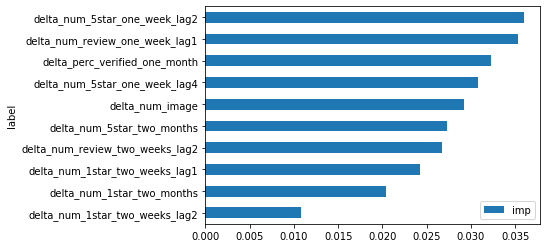

In [620]:
imp_coef[:10].set_index('label').plot.barh()